In [ ]:
# the following fixes are highly recommended

# allow oversubscription for openMPI
from amuse.support import options
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"] = "true"

# use lower cpu resources for idle codes
options.GlobalOptions.instance().override_value_for_option(
    "polling_interval_in_milliseconds", 10)

## Set up the amuse simulation
This file will be used to test the validity of the BT_optimizer. We will first assume circular orbits.

In [ ]:
# imports
from amuse.units import units, constants
from amuse.lab import Particles, Particle
import matplotlib.pyplot as plt
import numpy as np
from amuse.community.brutus.interface import Brutus
from amuse.units import nbody_system
import tqdm

In [ ]:
# define some basic functions
def relative_orbital_velocity(mass, distance):
    return (constants.G * mass / distance).sqrt()


def hill_radius(M, m, a):
    return a * (m / (3 * M))**(1/3)


def plot_system(system, velocities=True, title='System'):
    fig, ax = plt.subplots()
    for particle in system:
        ax.plot(particle.x.value_in(units.AU),
                particle.y.value_in(units.AU), 'o')
    if velocities:
        for particle in system:
            ax.quiver(particle.x.value_in(units.AU), particle.y.value_in(units.AU), particle.vx.value_in(
                units.AU / units.day), particle.vy.value_in(units.AU / units.day))
    ax.set_aspect('equal')
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_title(title)
    plt.show()

In [ ]:
# first generate a single 3 body system to test the Brutus code
masses = [1.0, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 10e-9] | units.MSun


def generate_n_body_system(n, masses=masses, phaseseed=42, center=True):
    '''
    Generate a system of n bodies with given masses and phases. The first body is a star, the rest are planets.
    The masses of the planets are given in the masses list, the mass of the star is 1 MSun. 
    By phase, we mean how far along in their orbits the planets start.

    :param int n: int, the number of bodies in the system
    :param list masses: list of floats, the masses of the planets in MSun
    :param phaseseed: seed to generate the phases of the planets
    '''
    # create the phases
    np.random.seed(phaseseed)
    phases = np.random.rand(n) * 2 * np.pi

    system = Particles(n)
    system.mass = masses[:n]
    system.name = ['star'] + ['planet{}'.format(i) for i in range(1, n)]
    # set the star parameters
    system[0].position = (0, 0, 0) | units.AU
    system[0].velocity = (0, 0, 0) | units.kms
    # set the planet parameters. Calculate the distances based on the Hill radii
    distance = []
    for i in range(1, n):
        if i == 1:
            distance.append(1 | units.AU)
        else:
            distance.append(
                distance[-1] + 10 * hill_radius(system[0].mass, system[i].mass, distance[-1]))
    # set the positions and velocities
    for i in range(1, n):
        r = distance[i-1].value_in(units.AU)
        system[i].position = (r * np.cos(phases[i-1]), r * np.sin(phases[i-1]),
                              np.random.uniform(-0.001, 0.001)) | units.AU
        vorb = relative_orbital_velocity(
            system.total_mass(), distance[i-1]).value_in(units.kms)
        system[i].velocity = (-vorb * np.sin(phases[i-1]), vorb *
                              np.cos(phases[i-1]), np.random.uniform(-0.01, 0.01)) | units.kms
    # center the system
    if center:
        system.move_to_center()
    return system

['star' 'planet1' 'planet2' 'planet3']


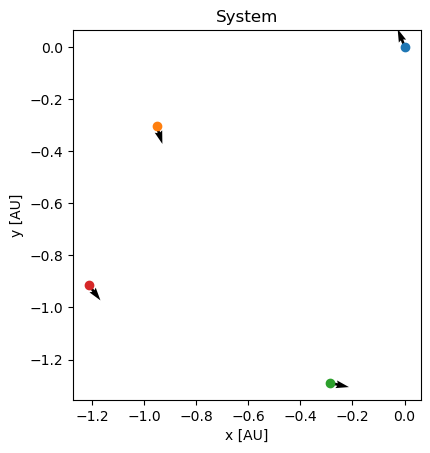

In [5]:
test_system = generate_n_body_system(4, phaseseed=0)
print(test_system.name)
plot_system(test_system)

Cool! Now we'd like to generate 100 of these systems, and evolve them by integrating them for a certain time. This time will have to be chosen in tandem with the BT optimizer.

In [ ]:
# first initialize 100 systems with 3 planets each
def create_systems(n_systems, n_planets, masses=masses):
    '''
    Create n_systems systems with n_planets planets each. The masses of the planets are given in the masses.

    :param int n_systems: the number of systems to create
    :param int n_planets: the number of planets in each system
    :param list masses: list of floats, the masses of the planets in MSun
    '''
    systems = []
    for i in range(n_systems):
        system = generate_n_body_system(n_planets, masses, phaseseed=i)
        systems.append(system)
    return systems


def evolve_systems(systems, end_time, n_steps, converter=nbody_system.nbody_to_si(1 | units.Msun, 1 | units.AU),
                   plot=False, save_states=False):
    '''
    Evolve the systems to end_time in n_steps steps.

    :param list systems: list of Particles objects, the systems to evolve
    :param float end_time: the time to evolve to in days
    :param int n_steps: the number of steps to take
    '''

    # create a numpy array to store all the states' positions and velocities
    total_energy = np.zeros((len(systems), n_steps+1))
    all_states = np.zeros((len(systems), n_steps+1, len(systems[0]), 6))
    # store the initial states in the first row
    for sys_idx, system in enumerate(systems):
        if save_states:
            for part_idx, particle in enumerate(system):
                all_states[sys_idx, 0, part_idx] = np.array([particle.x.value_in(units.AU), particle.y.value_in(units.AU),
                                                             particle.z.value_in(units.AU), particle.vx.value_in(
                                                                 units.AU / units.day),
                                                             particle.vy.value_in(units.AU / units.day), particle.vz.value_in(units.AU / units.day)])

        total_energy[sys_idx, 0] = system.kinetic_energy().value_in(
            units.J) + system.potential_energy(G=constants.G).value_in(units.J)

        gravity = Brutus(converter)
        gravity.particles.add_particles(system)
        channel = gravity.particles.new_channel_to(system)
        stepsize = end_time.value_in(units.day) / n_steps
        times = np.arange(0, end_time.value_in(
            units.day)+stepsize, stepsize)[1:]

        for time_idx, time in enumerate(times):
            gravity.evolve_model(time | units.day)
            channel.copy()
            if plot:
                fig, ax = plt.subplots()
                for particle in system:
                    ax.plot(particle.x.value_in(units.AU),
                            particle.y.value_in(units.AU), 'o')
                for particle in system:
                    ax.quiver(particle.x.value_in(units.AU), particle.y.value_in(units.AU), particle.vx.value_in(
                        units.AU / units.day), particle.vy.value_in(units.AU / units.day))
                ax.set_aspect('equal')
                ax.set_xlabel('x [AU]')
                ax.set_ylabel('y [AU]')
                ax.set_title('system {}'.format(sys_idx))
                plt.show()
            if save_states:
                for part_idx, particle in enumerate(system):
                    all_states[sys_idx, time_idx+1, part_idx] = np.array([particle.x.value_in(units.AU), particle.y.value_in(units.AU),
                                                                          particle.z.value_in(units.AU), particle.vx.value_in(
                                                                              units.AU / units.day),
                                                                          particle.vy.value_in(units.AU / units.day), particle.vz.value_in(units.AU / units.day)])
            total_energy[sys_idx, time_idx+1] = system.kinetic_energy().value_in(units.J) \
                + system.potential_energy(G=constants.G).value_in(units.J)
        print('evoled system {}'.format(sys_idx))
    gravity.stop()
    return systems, all_states, total_energy


def plot_trajectory(system, states):
    fig, ax = plt.subplots()
    for particle in system:
        ax.plot(particle.x.value_in(units.AU),
                particle.y.value_in(units.AU), 'o')
    for particle in system:
        ax.quiver(particle.x.value_in(units.AU), particle.y.value_in(units.AU), particle.vx.value_in(
            units.AU / units.day), particle.vy.value_in(units.AU / units.day))
    ax.set_aspect('equal')
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_title('system')
    # plot the starting point of the system
    ax.plot(states[0, :, 0], states[0, :, 1], 'o',
            color='red', label='starting positions')
    ax.legend()
    ax.plot(states[:, :, 0], states[:, :, 1], color='black', alpha=0.2)
    plt.show()

In [ ]:
converter = nbody_system.nbody_to_si(1 | units.MSun, 1 | units.AU)
print("for this particular converter:")
print(
    f"  The gravitational constant G in nbody units is: {converter.to_nbody(constants.G)}. "
    "Note that this is not unitless!")
print(f"  1 day is {converter.to_nbody(1. | units.day)} in nbody units")
print(
    f"  1 nbody time corresponds to {converter.to_si(1 | nbody_system.time)} in SI units")

for this particular converter:
  The gravitational constant G in nbody units is: 1.0 length**3 * mass**-1 * time**-2. Note that this is not unitless!
  1 day is 0.0172042796415 time in nbody units
  1 nbody time corresponds to 5022006.25661 s in SI units


In [ ]:
# initialize the systems

n_bodies = 3
n_systems = 1

systems = create_systems(n_systems, n_bodies)
print('finished creating systems')

evolve_time = 200 | units.day
n_steps = 100
stepsize = (evolve_time / n_steps).value_in(units.day)

systems_evolved, all_states, total_energy = evolve_systems(
    systems, evolve_time, n_steps, plot=False, save_states=True)
print('finished evolving systems')

finished creating systems
evoled system 0
finished evolving systems


(1, 101)


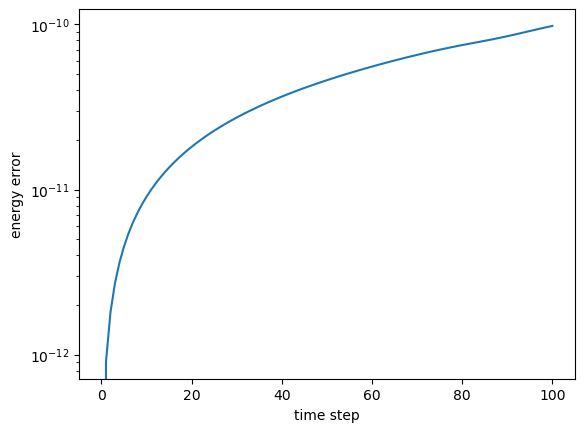

In [ ]:
# plot the energy error
print(np.shape(total_energy))
energy_error = np.abs(
    (total_energy[0, 0] - total_energy[0]) / total_energy[0, 0])
plt.semilogy((energy_error.T))
plt.xlabel('time step')
plt.ylabel('energy error')
plt.show()

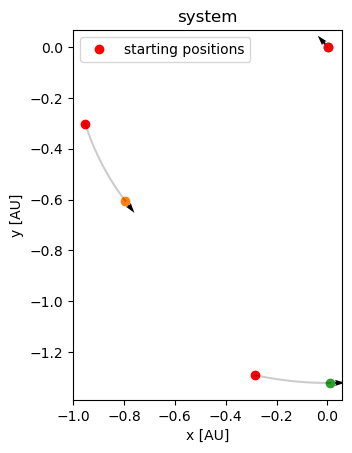

In [ ]:
plot_trajectory(systems[0], all_states[0])

It takes 2 minutes and 13 seconds to initialize and evolve 100 3 body systems for 30 days with n_step = 2. Now that we have our systems, we can continue with the next part: the optimizer.

## Using the optimizer
For every system, we now have 2 simulated data points which we can enter into the optimizer written by Andreas. I need to find out how it works now and use that to run it for each system. I imagine it will take a while.

In [ ]:
# set directory to find the other code
from Learning import BT_optimizer as bto
from Learning import NeuralODE as node
import os
import tensorflow as tf
os.chdir('/Users/bjhnieuwhof/Google Drive/Universiteit Leiden/Master Astronomy/Master Research Project/Arbeit')

2024-11-21 11:03:16.756869: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# use the learn_masses_not_horizons function to learn da masses.
# from tensorflow.keras.optimizers import Adam

# set the time parameters for the learning function
tau = 1  # in days
num_of_steps_in_do_step_between_costfunction_points = int(stepsize / tau)

print('evolve_time:', evolve_time)
print('n_steps in evolution with brutus:', n_steps)
# print('num_steps_in_do_step:', num_steps_in_do_step)
print('num_of_steps_in_do_step_between_costfunction_points:',
      num_of_steps_in_do_step_between_costfunction_points)
print('tau:', tau)

learned_masses = np.zeros((n_systems, n_bodies))
mass_runs = []

print('true masses:', masses[:n_bodies])

masses_perturbed = masses * (1 + np.random.normal(0, 0.00000001, len(masses)))
print('perturbed masses:', masses_perturbed[:n_bodies])

evolve_time: 20 day
n_steps in evolution with brutus: 100
num_of_steps_in_do_step_between_costfunction_points: 0
tau: 1
true masses: [1.0, 0.001, 0.0001] MSun
perturbed masses: [1.00000001266, 0.000999999994941, 0.000100000002545] 1.98892e+30 * kg


In [ ]:
# learn 1 system

# extract r and v from the all_states array
mass_runs = []
syst_index = 0
r = all_states[syst_index, :, :, :3]
v = all_states[syst_index, :, :, 3:]
# run the learning function
system_masses = node.learn_masses_not_horizons_multible_intermediate_points(optimizer=bto.BachelorThesisOptimizer(
    learning_rate=1e-3,
    shape=n_bodies,
    convergence_rate=1.001),
    tau=tau,
    n=n_bodies,
    r=r, v=v,
    m=[1, 1, 1],
    num_of_steps_in_do_step_between_costfunction_points=num_of_steps_in_do_step_between_costfunction_points,
    accuracy=1e-8,
    epochs=250,
    negative_mass_penalty=10)
mass_runs.append(system_masses)
learned_masses[syst_index] = system_masses[-1]
print(f'learned masses for system {syst_index}:', system_masses[-1])

2024-11-21 11:42:14.677621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Tried to stack elements of an empty list with non-fully-defined element_shape: [18,?]
	 [[{{node map/TensorArrayV2Stack/TensorListStack}}]]


InvalidArgumentError: Graph execution error:

Detected at node map/TensorArrayV2Stack/TensorListStack defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/opt/miniconda3/envs/nbody/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/opt/miniconda3/envs/nbody/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/opt/miniconda3/envs/nbody/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/opt/miniconda3/envs/nbody/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/folders/5w/pthft8q53_924502fx0_8m800000gn/T/ipykernel_7290/3032441762.py", line 9, in <module>

  File "/Users/bjhnieuwhof/Google Drive/Universiteit Leiden/Master Astronomy/Master Research Project/Arbeit/Learning/NeuralODE.py", line 666, in learn_masses_not_horizons_multible_intermediate_points

  File "/Users/bjhnieuwhof/Google Drive/Universiteit Leiden/Master Astronomy/Master Research Project/Arbeit/Learning/NeuralODE.py", line 267, in backwards_map_fn

Tried to stack elements of an empty list with non-fully-defined element_shape: [18,?]
	 [[{{node map/TensorArrayV2Stack/TensorListStack}}]] [Op:__inference_backwards_map_fn_112312]

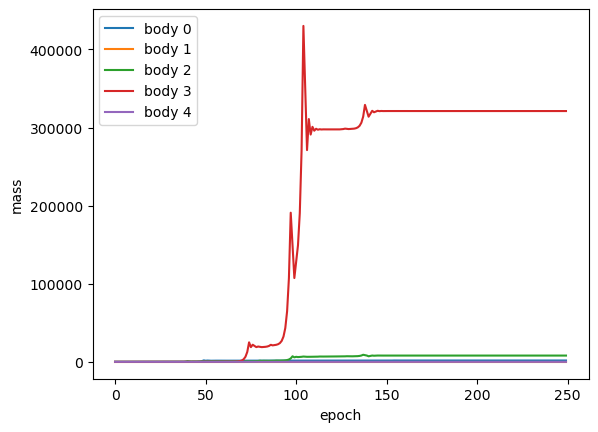

In [24]:
# plot the mass runs
fig, ax = plt.subplots()
massrun = np.array(mass_runs)[0]
for i in range(n_bodies):
    ax.plot(massrun[:, i], label=f'body {i}')
ax.set_xlabel('epoch')
ax.set_ylabel('mass')
ax.legend()
plt.show()

In [ ]:
# mass_runs = []
# for syst_index in range(len(systems_evolved)):
#     # extract r and v from the all_states array
#     r = all_states[syst_index, :, :, :3]
#     v = all_states[syst_index, :, :, 3:]
#     # run the learning function
#     system_masses = node.learn_masses_not_horizons_multible_intermediate_points(optimizer = bto.BachelorThesisOptimizer(
#                                 learning_rate=1e-3,
#                                 shape=n_bodies,
#                                 convergence_rate=1.001),
#                                        tau = tau,
#                                        n = n_bodies,
#                                        r = r, v = v,
#                                        m = [1, 1, 1, 1],
#                                        num_of_steps_in_do_step_between_costfunction_points = num_of_steps_in_do_step_between_costfunction_points,
#                                        accuracy = 1e-30,
#                                        epochs = 250,
#                                        negative_mass_penalty=10)
#     mass_runs.append(system_masses)
#     learned_masses[syst_index] = system_masses[-1]
#     print(f'learned masses for system {syst_index}:', system_masses[-1])

[ 1.002  0.998  0.998  0.998]
[ 1.006  0.994  0.994  0.994]
[ 1.014  0.986  0.986  0.986]
[ 1.03  0.97  0.97  0.97]
[ 1.062  0.938  0.938  0.938]
[ 1.126  0.874  0.874  0.874]
[ 1.094  0.746  0.746  0.746]
[ 1.062  0.49   0.49   0.49 ]
[ 0.99806394 -0.022      -0.022      -0.022     ]
[ 1.03003197  0.234       0.234       0.234     ]
[ 1.01404795  0.106       0.106       0.106     ]
[ 0.99806394 -0.022      -0.022      -0.022     ]
[ 1.00605594  0.042       0.042       0.042     ]
[ 1.00205994  0.01        0.01        0.01      ]
[ 0.99806394 -0.022      -0.022      -0.022     ]
[ 1.00006194 -0.006      -0.006      -0.006     ]
[ 1.00205994  0.01        0.01        0.01      ]
[ 1.00106094  0.002       0.002       0.002     ]
[ 1.00156044 -0.006      -0.006      -0.006     ]
[ 1.00131069 -0.002      -0.002      -0.002     ]
[ 1.00106094  0.002       0.002       0.002     ]
[  1.00118581e+00  -1.30104261e-16  -1.30104261e-16  -1.30104261e-16]
[  1.00112338e+00   1.00000000e-03   1.00000

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to handle the mass learning process for a single system


def process_system(syst_index):
    r = all_states[syst_index, :, :, :3]
    v = all_states[syst_index, :, :, 3:]
    # Run the learning function
    system_masses = node.learn_masses_not_horizons_multible_intermediate_points(
        optimizer=bto.BachelorThesisOptimizer(
            learning_rate=1e-3,
            shape=n_bodies,
            convergence_rate=1.001
        ),
        tau=tau,
        n=n_bodies,
        r=r,
        v=v,
        m=[1, 1, 1, 1, 1],
        num_of_steps_in_do_step_between_costfunction_points=num_of_steps_in_do_step_between_costfunction_points,
        accuracy=1e-8,
        epochs=250,
        negative_mass_penalty=10
    )
    learned_masses = system_masses[-1]
    print(f'learned masses for system {syst_index}:', learned_masses)
    return syst_index, system_masses


# Initialize mass_runs and learned_masses arrays
mass_runs = [None] * len(systems_evolved)
learned_masses = [None] * len(systems_evolved)

# Parallel processing with ProcessPoolExecutor
with ThreadPoolExecutor() as executor:
    # Submit tasks to the executor
    futures = [executor.submit(process_system, i)
               for i in range(len(systems_evolved))]

    # Collect the results as they complete
    for future in as_completed(futures):
        syst_index, system_masses = future.result()
        mass_runs[syst_index] = system_masses
        learned_masses[syst_index] = system_masses[-1]

[ 0.998  0.998  0.998  1.002  0.998]
[ 0.998  0.998  0.998  0.998  1.002]
[ 1.002  0.998  0.998  0.998  0.998]
[ 0.998  0.998  1.002  0.998  0.998]
[ 0.998  0.998  0.998  0.998  0.998]
[ 1.002  0.998  0.998  0.998  1.002]
[ 0.998  0.998  1.002  0.998  0.998]
[ 1.002  0.998  0.998  0.998  0.998]
[ 1.002  0.998  1.002  0.998  0.998]
[ 1.002  0.998  1.002  0.998  0.998]
[ 0.998  0.998  0.998  0.998  0.998]
[ 0.994  0.994  0.994  1.006  0.994]
[ 0.998  0.998  0.998  0.998  0.998]
[ 0.994  0.994  0.994  0.994  1.006]
[ 0.994  0.994  1.006  0.994  0.994]
[ 1.006  0.994  0.994  0.994  0.994]
[ 1.006  0.994  0.994  0.994  1.006]
[ 0.994  0.994  0.994  0.994  0.994]
[ 0.994  0.994  0.994  0.994  0.994]
[ 0.986  0.986  0.986  1.014  0.986]
[ 0.994  0.994  1.006  0.994  0.994]
[ 1.006  0.994  1.006  0.994  0.994]
[ 1.006  0.994  0.994  0.994  0.994]
[ 0.994  0.994  0.994  0.994  0.994]
[ 0.986  0.986  0.986  0.986  1.014]
[ 1.006  0.994  1.006  0.994  0.994]
[ 0.986  0.986  1.014  0.986  0.986]
[

## Analyzing the results
Below, we first plot a histogram of the absolute errors on the planet masses in solar masses. This is not very informative, as Solar masses is too large of a unit. The violin plot plots the relative errors, which should be more informative.

In [ ]:
import matplotlib as mpl
# save the massruns to a csv file
import csv
with open('mass_runs_5_bodies_short_traj.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerows(mass_runs)

# learned masses is just the last row of this

In [ ]:
# open a csv file

mass_runs = np.fromfile('mass_runs_4_bodies_short_traj.csv',
                        dtype=float, sep=',').reshape((n_systems, 250, 4))

print(mass_runs)

/var/folders/5w/pthft8q53_924502fx0_8m800000gn/T/ipykernel_84835/3014333984.py:3: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  mass_runs = np.fromfile('mass_runs_4_bodies_short_traj.csv', dtype=float, sep=',').reshape((n_systems, 250, 4))


NameError: name 'n_systems' is not defined

In [17]:
# create a filter for outliers which lie outside of 3 standard deviations
# Compute mean and standard deviation for each planet
learned_masses = np.array(learned_masses)
means = np.array(learned_masses).mean(axis=0)  # Mean mass for each planet
std_devs = learned_masses.std(axis=0)  # Standard deviation for each planet

# Calculate Q1, Q3, and IQR for each planet
Q1 = np.percentile(learned_masses, 25, axis=0)
Q3 = np.percentile(learned_masses, 75, axis=0)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR

# Identify outliers
outliers = (learned_masses < lower_bound) | (learned_masses > upper_bound)

# Check for any outliers in each system
systems_with_outliers = np.any(outliers, axis=1)

# Filter out systems with outliers
filtered_masses = learned_masses[~systems_with_outliers]

print(f'Number of systems with outliers: {np.sum(systems_with_outliers)}')

Number of systems with outliers: 29


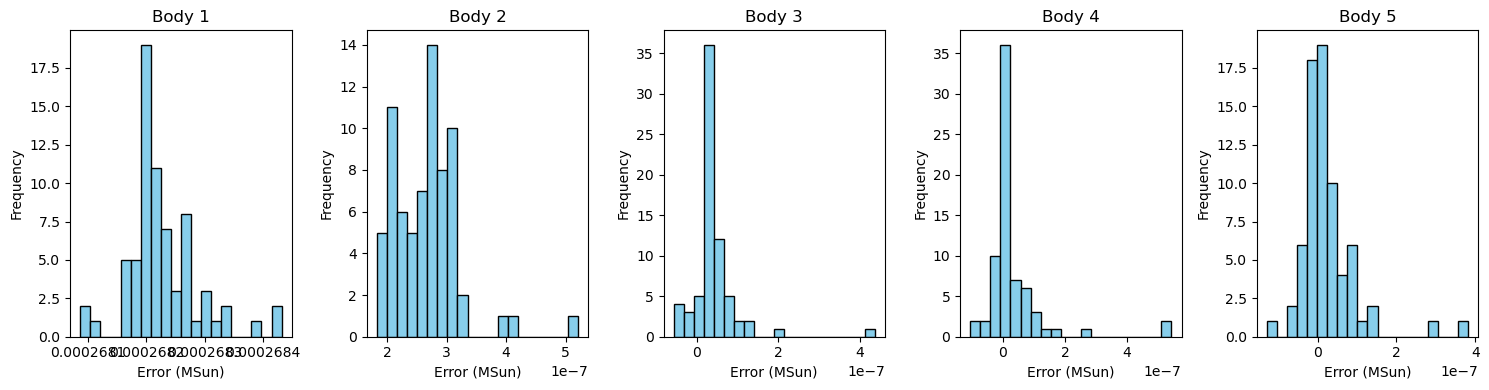

In [18]:

errors = filtered_masses - masses.value_in(units.Msun)[:n_bodies]
fig, axs = plt.subplots(1, n_bodies, figsize=(15, 4))
for i in range(n_bodies):
    axs[i].hist(errors[:, i], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Body {i+1}')
    axs[i].set_xlabel('Error (MSun)')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The cell below creates a violin plot of the relative errors. The mean relative error is also printed. Some information is sadly lost because there are outliers. The question is, what to do with these outliers? 

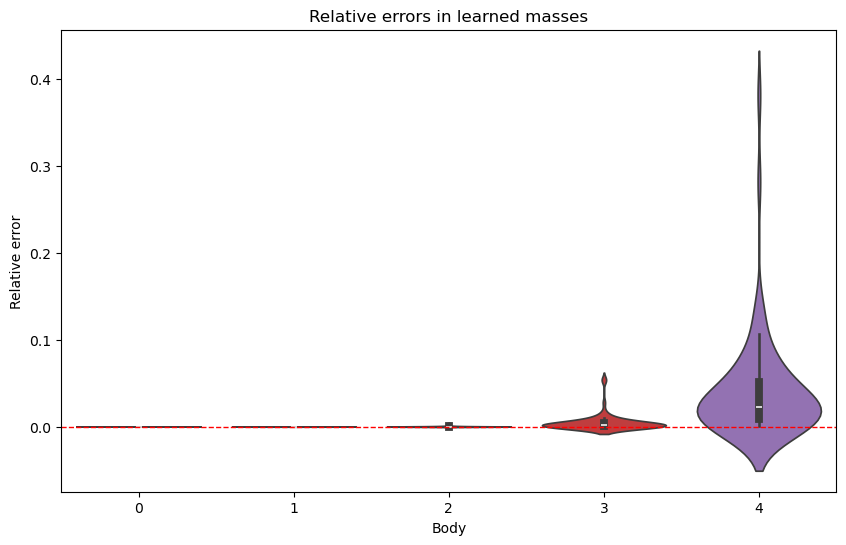

-----------------------------------------
Body 1:
  True mass: 1.0 MSun
  Median learned mass: 1.0002682674683634 MSun
  Standard deviation of learned masses: 6.196017203790424e-08
  Mean relative error: 0.000268227612076705
  Relative error standard deviation: 6.196017203790424e-08
-----------------------------------------
Body 2:
  True mass: 0.001 MSun
  Median learned mass: 0.0010002339076000627 MSun
  Standard deviation of learned masses: 5.3782274214852514e-08
  Mean relative error: 0.0002674192691531521
  Relative error standard deviation: 5.378227421485251e-05
-----------------------------------------
Body 3:
  True mass: 0.0001 MSun
  Median learned mass: 0.00010004279802147491 MSun
  Standard deviation of learned masses: 6.061051118616344e-08
  Mean relative error: 0.0004803252145888713
  Relative error standard deviation: 0.000552492412380851
-----------------------------------------
Body 4:
  True mass: 1e-05 MSun
  Median learned mass: 9.964894544188037e-06 MSun
  Standard

In [ ]:

import seaborn as sns
absolute_errors = np.abs(
    (filtered_masses - masses.value_in(units.Msun)[:n_bodies]))
relative_errors = absolute_errors / masses.value_in(units.Msun)[:n_bodies]

# absolute error violin plot


def violin_plot(data, title, ylabel):
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=data)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Body')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# violin_plot(absolute_errors, 'Absolute errors in learned masses', 'Absolute error (MSun)')
violin_plot(relative_errors, 'Relative errors in learned masses',
            'Relative error')

for i in range(n_bodies):
    print('-----------------------------------------')
    print(f'Body {i+1}:')
    print(f'  True mass: {masses[i].value_in(units.MSun)} MSun')
    print(f'  Median learned mass: {np.median(filtered_masses[-1][i])} MSun')
    print(
        f'  Standard deviation of learned masses: {filtered_masses[:, i].std()}')
    print(f'  Mean relative error: {relative_errors[:, i].mean()}')
    print(
        f'  Relative error standard deviation: {relative_errors[:, i].std()}')

<>:4: SyntaxWarning: invalid escape sequence '\ '
<>:4: SyntaxWarning: invalid escape sequence '\ '
/var/folders/5w/pthft8q53_924502fx0_8m800000gn/T/ipykernel_2861/1367203579.py:4: SyntaxWarning: invalid escape sequence '\ '
  plt.ylabel('mean\ relative error')


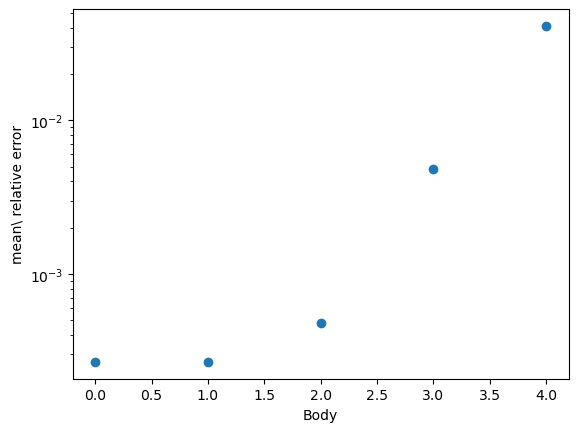

In [26]:
# plot the error as function of n_body
plt.semilogy(np.arange(n_bodies), relative_errors.mean(axis=0), 'o')
plt.xlabel('Body')
plt.ylabel('mean\ relative error')
plt.show()

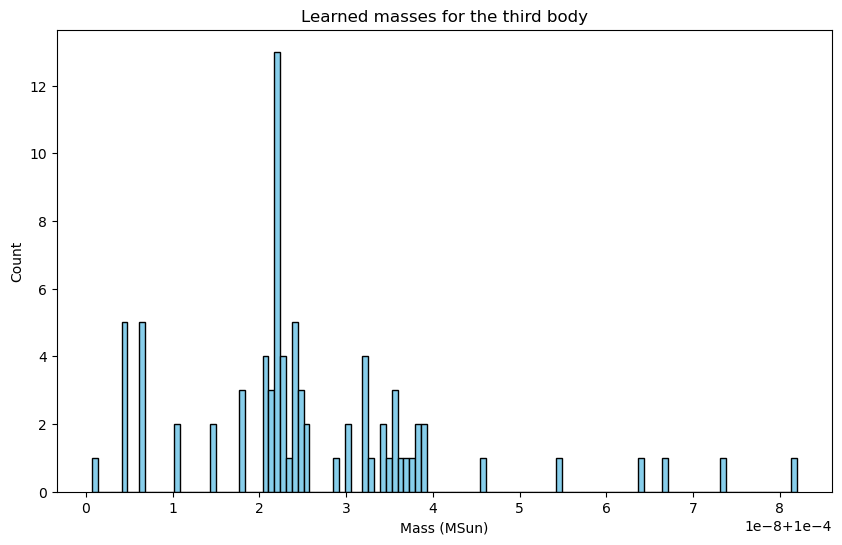

In [ ]:
# # plot all the learned masses for the third body
# plt.figure(figsize=(10, 6))
# plt.hist(filtered_masses[:, -1], bins=120, color='skyblue', edgecolor='black')
# plt.xlabel('Mass (MSun)')
# plt.ylabel('Count')
# plt.title('Learned masses for the third body')
# plt.show()